# <font color='orange'>Kaggle Facial Keypoints Challenge</font>

## Challenge by Snapshopr Research

### Solution by: Anmol Sharma

------------------------------------------------------------------------

Disclaimer: The solution given here is inspired by Daniel Nouri's tutorial on the same challenge. However, it is strongly emphasized that the solution below is a work my own, and proposes an entirely new approach to the challenge. The tutorial is merely used as a benchmark. 

We stand on the shoulders of giants. 

--------------------------------------

### <font color='red'>Index</font>
#### -> Load Data
#### -> Train Small Neural Networks
#### -> Novel Approach to Impute Missing Values
Predict the values of missing columns using a trained Neural Network!
#### -> Train Small Neural Networks to get Improvement Metrics
#### -> Data Augmentation 
New approach that is much more computationally efficient than other used techniques! 
Not undertaken due to lack of resources. A CNN will obviously outperform a simple NN architecture used here
#### -> Train Small Neural Networks to get Improvement Metrics

---------------------------

# <font color='red'>Loading Data and Initial Analysis</font>

In [1]:
import numpy as np
import os
import glob
import numpy as np
import time
import pandas
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import theano
import theano.tensor as T
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as pyplot
import matplotlib.patches as patches
import keras
from keras import callbacks
from keras.utils.layer_utils import model_summary
import joblib
from datetime import datetime

Using Theano backend.
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [46]:
trainFile = './training.csv'
testFile = './test.csv'

data = read_csv(os.path.expanduser(trainFile))

print("Original dataset shape: {}".format(data.shape))

Original dataset shape: (7049, 31)


In [47]:
print(data['Image'])

['Data/cols.pkl']

#### The images are supplied in a rather strange manner, in the form of a string of image intensities. We need to convert the string to a numpy array

In [4]:
# apply inplace anonymous function to convert the data to numpy arrays
data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))

#### The challenge page says there are missing values in the target variable. Let's find out in which columns we have NaN values

In [5]:
dicts = {}
for i in range(30):
    dicts[i+1] = np.shape(np.where(np.isnan(data[data.columns[i]].values) == True))[1]

# map dictionary keys to actual column names, we might need them later
columnNameDict = {}
for i in range(30):
    columnNameDict[i+1] = list(data)[i]

In [6]:
dicts

{1: 10,
 2: 10,
 3: 13,
 4: 13,
 5: 4778,
 6: 4778,
 7: 4782,
 8: 4782,
 9: 4781,
 10: 4781,
 11: 4781,
 12: 4781,
 13: 4779,
 14: 4779,
 15: 4824,
 16: 4824,
 17: 4779,
 18: 4779,
 19: 4813,
 20: 4813,
 21: 0,
 22: 0,
 23: 4780,
 24: 4780,
 25: 4779,
 26: 4779,
 27: 4774,
 28: 4774,
 29: 33,
 30: 33}

#### Now its a problem. All target columns have some missing values. Lets drop all rows with NaN values first and set up an initial benchmark. Later we will try some imputation method to see if performance increases

In [7]:
# normalize the images to lie between [0 1], and stack them vertically to form X array
dataBackup = data
data = data.dropna()

X = np.vstack(data['Image'].values) / 255.
X = X.astype(dtype=np.float32)

y = data[data.columns[0:-1]].values
y = (y - 48.) / 48.
y = y.astype(np.float32)

print("Shape of X: {}".format(X.shape))

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

Shape of X: (2140, 9216)
X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


## <font color='red'>Analysis</font>

### ONLY around 30% of the data has all the target values intact! Let's try to set up a benchmark for the challenge which we will improve upon in the later stages

#### Some helper functions and dividing the data into Train/Validation/Test using the split ratio 90/10

In [2]:
dicts = {}
columnNameDict = {}

def getData(test=False, dropNaN=True):
    
    trainFile = './training.csv'
    testFile = './test.csv'
    
    if test == True:
        fileName = testFile
    else:
        fileName = trainFile

    data = read_csv(os.path.expanduser(fileName))
    
    if test == False:
        cols = data.columns[:-1]
    
        import joblib
        joblib.dump(cols, 'Data/cols.pkl', compress=3)
        global dicts
        for i in range(30):
            dicts[i+1] = np.shape(np.where(np.isnan(data[data.columns[i]].values) == True))[1]

        # map dictionary keys to actual column names, we might need them later

        global columnNameDict
        for i in range(30):
            columnNameDict[i+1] = list(data)[i]
    
    print("Original dataset shape: {}".format(data.shape))
    
    # apply inplace anonymous function to convert the data to numpy arrays
    data['Image'] = data['Image'].apply(lambda x: np.fromstring(x, sep=' '))
    
    if dropNaN == True:
        data = data.dropna()

    X = np.vstack(data['Image'].values) / 255.
    X = X.astype(dtype=np.float32)
    
    if test == False:
        y = data[data.columns[0:-1]].values
        y = (y - 48.) / 48.
        y = y.astype(np.float32)
    else:
        y = None

    print("Shape of X: {}".format(X.shape))

    print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
        X.shape, X.min(), X.max()))
    
    if test == False:
        print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
            y.shape, y.min(), y.max()))
    
    return X, y

def getSplit(X, y, trainRatio=90, valRatio=10, dropNaN=False):
    
    if dropNaN == True:
        print("Dropping rows with NaNs")
        X = X[~np.isnan(y).any(axis=1)]
        y = y[~np.isnan(y).any(axis=1)]
        print("Shapes of matrices after dropping NaN rows: {}, {}".format(np.shape(X), np.shape(y)))
    
    trainNum = int(np.shape(X)[0]*(trainRatio/100.))

    X_train = X[0:trainNum, :]
    y_train = y[0:trainNum, :]

    X_val = X[trainNum:np.shape(X)[0], :]
    y_val = y[trainNum:np.shape(X)[0], :]

    print("Shapes of matrices:\nX_train: {}\ny_train: {}\nX_val: {}\ny_val: {}"
              .format(np.shape(X_train), np.shape(y_train), np.shape(X_val), np.shape(y_val)))
    print("Datatypes of matrices:\nX_train: {}\ny_train: {}\nX_val: {}\ny_val: {}"
              .format(X_train.dtype, y_train.dtype, X_val.dtype, y_val.dtype))
    print(np.max(y_train))
    print(np.min(y_train))
    return X_train, y_train, X_val, y_val

def generate_submission(predictions, modelName):
    test_labels = predictions
    test_labels = (test_labels * 48) + 48
    test_labels = test_labels.clip(0, 96)
    lookup_table = pandas.read_csv("Data/IdLookupTable.csv")
    values = []
    cols = joblib.load('Data/cols.pkl')
    df = pandas.DataFrame(test_labels, columns=cols)
    
    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = pandas.DataFrame(values, columns=('RowId', 'Location'))
    filename = 'submission-model-{}-{}.csv'.format(modelName, now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))
    

#### Helper functions which will help us visualize the training error both live during training after training is done

In [3]:
def EpochDrawer(history, save_filename = None):
    pyplot.plot(history.history['loss'], linewidth=3, label="train")
    pyplot.plot(history.history['val_loss'], linewidth=3, label="valid")
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.show()

class PlotHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs={}):
        self.epoch.append(epoch)
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []
            self.history[k].append(v)
        pyplot.plot(self.history['val_loss'], linewidth=3, color='b')
        pyplot.pause(0.5)
        time.sleep(0.05)

In [21]:
def buildNN(X_train, y_train, X_val=None, y_val=None, 
            nb_epoch=100, batch_size=20, 
            nb_hidden_layers=1, nb_hidden_nodes=100, 
            lr=1.0, dropout=True, dropout_num = 2, dropout_p=0.5):
    nb_classes = 30

    model = Sequential()
    
    model.add(Dense(nb_hidden_nodes, input_shape=(9216,), init='uniform'))
    model.add(Activation('relu'))
    
    if dropout == True:
        model.add(Dropout(dropout_p))
    
    t = 1
    while (t != nb_hidden_layers):
        model.add(Dense(nb_hidden_nodes, init='uniform'))
        model.add(Activation('relu'))
        if dropout == True and dropout_num >= t+1:
            model.add(Dropout(dropout_p))
        t += 1
    
    # output layer
    model.add(Dense(30, init='uniform'))

    optim_adadelta = keras.optimizers.Adadelta(lr=lr)
    optim_adagrad = keras.optimizers.Adagrad()

    # early stopping criteria
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    
    print(model.summary())
    print("Compiling model...")
    # compile theano function to train the model
    model.compile(loss='mean_squared_error', optimizer=optim_adadelta)
    
    print("Training start...")
    if not(X_val == None or y_val == None):
        history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_val, y_val),
              callbacks=[early_stop],show_accuracy=False, verbose=1, shuffle=True)
    else:
        history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              callbacks=[early_stop],show_accuracy=False, verbose=1, shuffle=True)
    return model, history

def buildCNN(X_train, y_train, X_val, y_val, 
            nb_epoch=100, batch_size=20, lr=1.0):
    nb_classes = 30
    model = Sequential()
    
    model.add(Convolution2D(32, 3, 3,
                        border_mode='valid',
                        input_shape=(1, 96, 96)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(4, 4)))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    
    # early stopping criteria
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
    
    print(model.summary())
    print("Compiling model...")
    optim_adadelta = keras.optimizers.Adadelta(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optim_adadelta)

    history = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              show_accuracy=False, verbose=1, callbacks=[early_stop], validation_data=(X_val, y_val))
    return model, history

In [5]:
w_X, w_y = getData(test=False, dropNaN=False)
X_train, y_train, X_val, y_val = getSplit(w_X, w_y, dropNaN=True)

Original dataset shape: (7049, 31)
Shape of X: (7049, 9216)
X.shape == (7049, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7049, 30); y.min == nan; y.max == nan
Dropping rows with NaNs
Shapes of matrices after dropping NaN rows: (2140, 9216), (2140, 30)
Shapes of matrices:
X_train: (1926, 9216)
y_train: (1926, 30)
X_val: (214, 9216)
y_val: (214, 30)
Datatypes of matrices:
X_train: float32
y_train: float32
X_val: float32
y_val: float32
0.99602
-0.903958


# <font color='green'>Train our first ANN with 100 nodes and AdaDelta optimizer</font>

In [7]:
model1, history1 = buildNN(X_train, y_train, X_val, y_val, 
                            nb_epoch=200, batch_size=20, 
                            nb_hidden_layers=1, nb_hidden_nodes=100, 
                            lr=1.0, dropout=False, dropout_num = None, dropout_p=None)


--------------------------------------------------------------------------------
Initial input shape: (None, 9216)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 100)                   921700              
Activation (activation)       (None, 100)                   0                   
Dense (dense)                 (None, 30)                    3030                
--------------------------------------------------------------------------------
Total params: 924730
--------------------------------------------------------------------------------
None
Compiling model...
Training start...
Train on 1926 samples, validate on 214 samples
Epoch 1/200
1926/1926 [==============================] - 3s - loss: 0.1065 - val_loss: 0.0474
Epoch 2/200
1926/1926 [==========

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [10]:
saveModel = True

# very memory intensive, freezes my laptop. Avoid. 
if saveModel == True:
    import cPickle as pickle
    with open("model1.pckl", "wb") as f:
        pickle.dump(model1, f, -1)

Root Mean Square Error: 3.42944641213


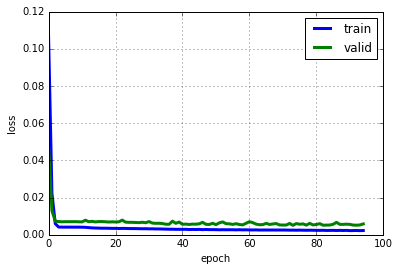

In [11]:
# The competition will evaluate entries based on RMSE value 
# https://www.kaggle.com/c/facial-keypoints-detection/details/evaluation
# We used Mean Squared Error loss function, so to find RMSE, first we square root the error,
# and then multiply by 48 to compensate for scaling of target values to [-1, 1]

rmse = np.sqrt(np.min(history1.history['val_loss'])) * 48
print("Root Mean Square Error: {}".format(rmse))
%matplotlib inline
EpochDrawer(history1)

# <font color='red'>Submission 1</font>
Let's generate a submission and see what our rank on Leaderboard is

In [54]:
testData, cols = getData(test=True)
generate_submission(model1.predict(testData), '1')

Original dataset shape: (1783, 2)
Shape of X: (1783, 9216)
X.shape == (1783, 9216); X.min == 0.000; X.max == 1.000
Wrote submission-model1-2016-04-02T18-20-49.465731.csv


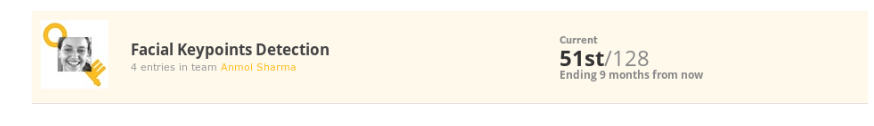

In [35]:
import cv2
%matplotlib inline
rank = cv2.imread("./snapshot3.png")
fig = pyplot.figure(figsize=(15,15))
pyplot.axis('off')
pyplot.imshow(rank)
pyplot.show()

# <font color='red'>3.72034 - RANK 51!</font> Not bad. Let's try to improve it

# Analysis
#### 1. Although the RMSE looks good at first, the training performance stagnanted. This demonstrates a need for a more complex network. Let's increase the number of hidden nodes in the network.  
#### 2. The learning rate is too high which is apparent from the sharp decrease of loss in the first few epochs but stagnant performance in the subsequent epochs. AdaDelta starts with a rather large learning rate of 0.8, so lets try decreasing it. 

# Lets increase the hidden neurons and decrease the initial learning rate of AdaDelta

In [56]:
model2, history2 = buildNN(X_train, y_train, X_val, y_val, 
                            nb_epoch=200, batch_size=20, 
                            nb_hidden_layers=1, nb_hidden_nodes=200, 
                            lr=.65, dropout=False, dropout_num = None, dropout_p=None)
saveModel = False

# very memory intensive, freezes my laptop. Avoid. 
if saveModel == True:
    import joblib
    joblib.dump(model2, "model2.pckl", "wb", protocol=-1)

--------------------------------------------------------------------------------
Initial input shape: (None, 9216)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 200)                   1843400             
Activation (activation)       (None, 200)                   0                   
Dense (dense)                 (None, 30)                    6030                
--------------------------------------------------------------------------------
Total params: 1849430
--------------------------------------------------------------------------------
None
Compiling model...
Training start...
Train on 1926 samples, validate on 214 samples
Epoch 1/200
1926/1926 [==============================] - 5s - loss: 0.0697 - val_loss: 0.0120
Epoch 2/200
1926/1926 [=========

Root Mean Square Error: 3.25309033225


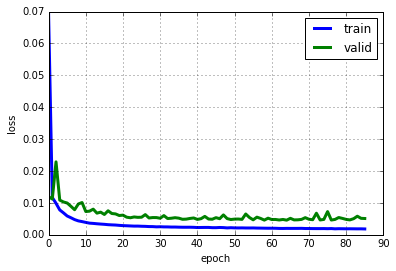

In [58]:
rmse = np.sqrt(np.min(history2.history['val_loss'])) * 48
print("Root Mean Square Error: {}".format(rmse))
%matplotlib inline
EpochDrawer(history2)

# <font color='red'>Submission 2</font>

In [59]:
# testData, cols = getData(test=True)
generate_submission(model1.predict(testData), '2')

Wrote submission-model-2-2016-04-02T18-56-32.158881.csv


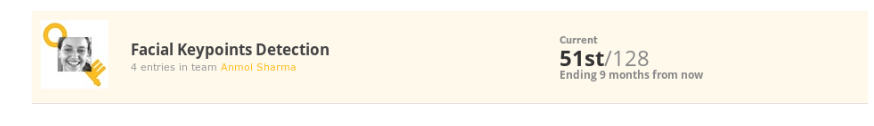

In [36]:
%matplotlib inline
rank = cv2.imread("./snapshot3.png")
fig = pyplot.figure(figsize=(15,15))
pyplot.axis('off')
pyplot.imshow(rank)
pyplot.show()

# <font color='red'>3.72034 - RANK 51</font> No change. Let's try something else now. 

# Analysis
#### 1. The network stopped improving at around the same time as the earlier network. This seems like a local minima where both networks are getting stuck. However, this time the RMSE is a bit better. 
#### 2. Daniel Nouri reports that using a Convolutional Neural Network drastically improves performance, but I do not have the infrastructure currently to implement that solution. I can only work towards improving this network more. 
#### 3. We need some more data, and for that, we need to use the 70% of the data we threw away. 


# <font color='green'>Missing Value Imputation</font>
## Now let us do something interesting. We are going to impute the missing target values by predicting them with our best classifier. We will only keep those target values that we require and discard other value predictions by our classifier. 

## This method is arguably better than "mean", "most_frequent" or "k-NN" value imputation, and ofcourse a significantly better solution than just throwing away data. This is because the values are imputed by a trained classifier, and not by simple statistical heuristics. 

In [5]:
import cPickle as pickle
with open("model1.pckl", "r") as f:
    model1 = pickle.load(f)

w_X, w_y = getData(test=False, dropNaN=False)

Original dataset shape: (7049, 31)
Shape of X: (7049, 9216)
X.shape == (7049, 9216); X.min == 0.000; X.max == 1.000
y.shape == (7049, 30); y.min == nan; y.max == nan


In [6]:
r, c = np.where(np.isnan(w_y) == True)

In [7]:
# debug, I am so paranoid. Make sure this index contains a NaN
w_y[r[1],c[1]]

nan

In [8]:
nanRows = np.unique(r)
print("Number of samples with missing values: %d" % len(nanRows))

Number of samples with missing values: 4909


## We have our best trained model in model1. We use that model to predict the values of the missing target values of samples. 
## Steps:
### 1. Create a dummy matrix to hold the predictions, with the same shape as that of y
### 2. Insert all all predictions in that dummy matrix. The Dummy matrix helps us keep track of the actual indices of samples corresponding to the supplied dataset. 
### 3. We are only interested in the predictions of those targets values that were originally NaN in the dataset. Hence,  from the predicted values inserted in the dummy matrix, get all those values which were originally NaNs in the training data. Leave the rest. We dont need the other predictions. 

In [9]:
dummyMatrix = np.zeros(np.shape(w_y))
import timeit
start = timeit.default_timer()
dummyMatrix[nanRows, :] = model1.predict(w_X[nanRows, :])
stop = timeit.default_timer()
print("Time taken to process {} Images -> {} sec".format(len(nanRows), (stop - start)))

Time taken to process 4909 Images -> 0.468426942825 sec


In [10]:
w_y[r,c] = dummyMatrix[r, c]

### 4. Confirm that no NaN exists anymore

In [11]:
np.where(np.isnan(w_y) == True)

(array([], dtype=int64), array([], dtype=int64))

# Train a model using the complete dataset formed by Imputing Values by Prediction

In [12]:
X_train, y_train, X_val, y_val = getSplit(w_X, w_y)

model2, history2 = buildNN(X_train, y_train, X_val, y_val, 
                            nb_epoch=200, batch_size=20, 
                            nb_hidden_layers=1, nb_hidden_nodes=200, 
                            lr=1.0, dropout=False, dropout_num = None, dropout_p=None)

saveModel = True

# very memory intensive, freezes my laptop. Avoid. 
if saveModel == True:
    import cPickle as pickle
    with open("model2.pckl", "wb") as f:
        pickle.dump(model2, f, -1)


Shapes of matrices:
X_train: (6344, 9216)
y_train: (6344, 30)
X_val: (705, 9216)
y_val: (705, 30)
Datatypes of matrices:
X_train: float32
y_train: float32
X_val: float32
y_val: float32
0.998659
-0.985696
--------------------------------------------------------------------------------
Initial input shape: (None, 9216)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 200)                   1843400             
Activation (activation)       (None, 200)                   0                   
Dense (dense)                 (None, 30)                    6030                
--------------------------------------------------------------------------------
Total params: 1849430
--------------------------------------------------------------------------------
None
Compil

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:38: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Root Mean Square Error: 2.33788338168


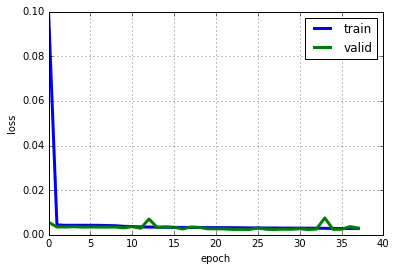

In [13]:
rmse = np.sqrt(np.min(history2.history['val_loss'])) * 48
print("Root Mean Square Error: {}".format(rmse))
%matplotlib inline
EpochDrawer(history2)

### <font color='green'>RMSE Looks really promising! Fingers crossed</font>

# <font color='red'>Submission 3</font>

In [16]:
testData, cols = getData(test=True)
generate_submission(model1.predict(testData), '3')

Wrote submission-model-3-2016-04-02T20-53-33.055912.csv


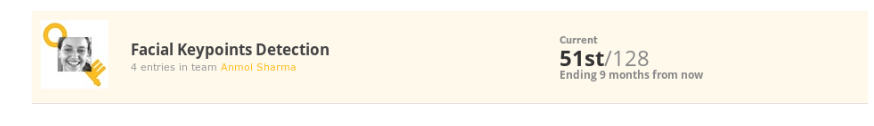

In [37]:
%matplotlib inline
rank = cv2.imread("./snapshot3.png")
fig = pyplot.figure(figsize=(15,15))
pyplot.axis('off')
pyplot.imshow(rank)
pyplot.show()

# <font color='red'>3.92266 - RANK 51</font> No change. 

# Data Augmentation by Horizontal Flipping

### The amount of data we have is low to design good models. Data Augmentation is necessary, and here we investigate augmentation by flipping the images horizontally. 

### When the images are flipped horizontally, the y-coordinates of the targets remain the same, but the x-coordinates change to (96 - x). This simple insight will save a lot of computation and hassles of finding out which target values will be "swapped" when the images are flipped horizontally. Daniel Nouri unfortunately approaches this problem using the later approach. 

### Here I will just subtract 96 from all the x-coordinates to get the new flipped target values. Both the image flipping and target flipping is a computationlly efficient operation thanks to NumPy. 

### As a matter of fact this augmentation can be had for virtually zero computation cost using a CPU run batch iterator. I could have implemented it if I used Lasagne or pure Theano and had ample time.  

In [17]:
# Flip the images using a simple numpy slice
def augmentData(X, y):
    X_reshaped = X.reshape(-1, 1, 96, 96)
    X_flipped = X_reshaped[:, :, :, ::-1]

    y_flipped = y * 48 + 48

    # Get the new target coordinates using the above described approach
    for j in range(0, 30, 2):
        print("# Changed {}".format(columnNameDict[j+1]))
        y_flipped[:, j] = 96 - y_flipped[:, j]

    # rescale the coordinates back to [-1,1]
    y_flipped = (y_flipped - 48.) / 48.
    print("Shape of Flipped images array: {}".format(np.shape(X_flipped)))
    return X_flipped, y_flipped

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)



# Changed left_eye_center_x
# Changed right_eye_center_x
# Changed left_eye_inner_corner_x
# Changed left_eye_outer_corner_x
# Changed right_eye_inner_corner_x
# Changed right_eye_outer_corner_x
# Changed left_eyebrow_inner_end_x
# Changed left_eyebrow_outer_end_x
# Changed right_eyebrow_inner_end_x
# Changed right_eyebrow_outer_end_x
# Changed nose_tip_x
# Changed mouth_left_corner_x
# Changed mouth_right_corner_x
# Changed mouth_center_top_lip_x
# Changed mouth_center_bottom_lip_x
Shape of Flipped images array: (7049, 1, 96, 96)


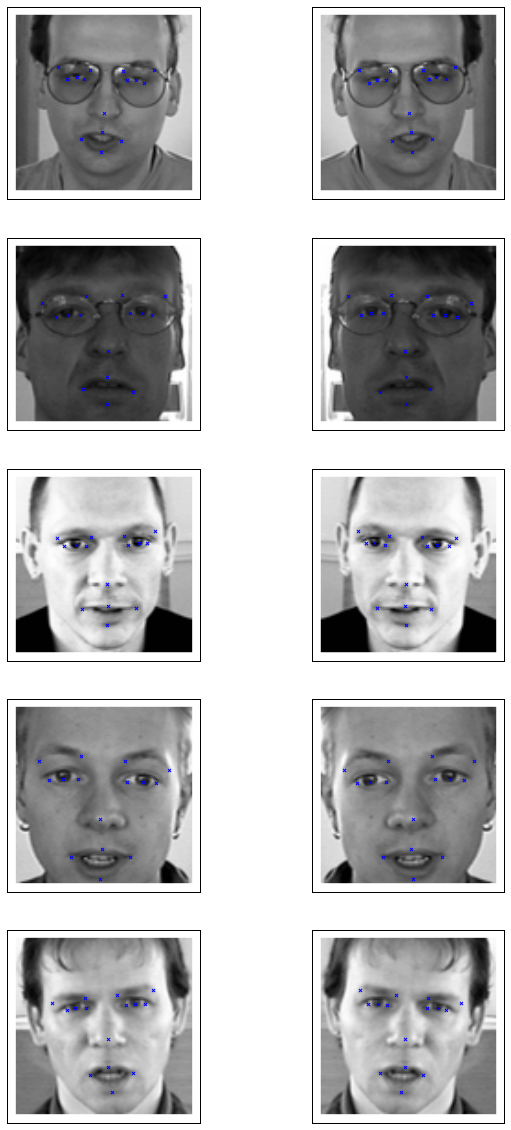

In [18]:
X_flipped, y_flipped = augmentData(w_X, w_y)
# plot two images:
%matplotlib inline
fig = pyplot.figure(figsize=(10, 20))
t = 12
for i in range(1, 10, 2):
    ax = fig.add_subplot(5, 2, i, xticks=[], yticks=[])
    plot_sample(w_X[t+i], w_y[t+i], ax)
    ax = fig.add_subplot(5, 2, i+1, xticks=[], yticks=[])
    plot_sample(X_flipped[t+i], y_flipped[t+i], ax)
pyplot.show()

In [19]:
X_augmented = np.vstack((w_X, X_flipped.reshape(-1, 9216)))
y_augmented = np.vstack((w_y, y_flipped))

print("Shapes of matrices:\nX_augmented: {}\ny_augmented: {}"
          .format(np.shape(X_augmented), np.shape(y_augmented)))

Shapes of matrices:
X_augmented: (14098, 9216)
y_augmented: (14098, 30)


In [20]:
X_train, y_train, X_val, y_val = getSplit(X_augmented, y_augmented, dropNaN=False)

Shapes of matrices:
X_train: (12688, 9216)
y_train: (12688, 30)
X_val: (1410, 9216)
y_val: (1410, 30)
Datatypes of matrices:
X_train: float32
y_train: float32
X_val: float32
y_val: float32
0.998659
-0.985696


### Since the data is much larger now, we would have to increase the model capacity as well. Hence we use a neural network with 2 hidden layers and 100 hidden nodes in each of it. 

### <font color='orange'>Cannot train networks this big on my laptop.</font>

#### <font color='black'>I have given above a prospective solution to solving this challenge. The major problems that are a part of this challenge are related to low amount of data and missing values in it. I have proposed techniques to solve both of the problems by using a novel imputation method based on predicting missing target values using a small ANN trained on remaining data, and then augmentation of data using horizontal image flipping. </font>

#### However due to lack of resources I would have to settle with a rather small network trained on only 30% of the training data. I could have considered other options like XGBoost but time constraints hindered that consideration. 

#### The following code is just a prospective solution of what most likely will work if trained properly. I have not implemented the below code to check the performance. <font color='red'>However I am confident that the CNN trained on 12688 samples would have outperformed the other models by a large margin</font>

In [33]:
model3, history3 = buildNN(X_train, y_train, X_val, y_val, 
                           nb_epoch=2, batch_size=20, 
                           nb_hidden_layers=3, nb_hidden_nodes=250, 
                           lr=1.0, dropout=True, dropout_num = 2, dropout_p=0.3)

--------------------------------------------------------------------------------
Initial input shape: (None, 9216)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Dense (dense)                 (None, 250)                   2304250             
Activation (activation)       (None, 250)                   0                   
Dropout (dropout)             (None, 250)                   0                   
Dense (dense)                 (None, 250)                   62750               
Activation (activation)       (None, 250)                   0                   
Dropout (dropout)             (None, 250)                   0                   
Dense (dense)                 (None, 250)                   62750               
Activation (activation)       (None, 250)                   0              

Root Mean Square Error: 11.6713468564


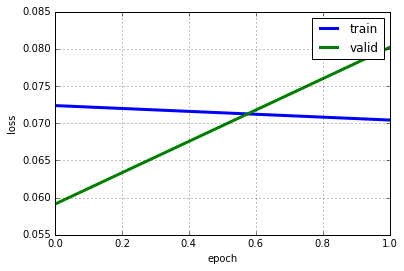

In [34]:
rmse = np.sqrt(np.min(history3.history['val_loss'])) * 48
print("Root Mean Square Error: {}".format(rmse))
%matplotlib inline
EpochDrawer(history3)

# import joblib
# joblib.dump(model3, "model3.pckl", "wb", compress=3, protocol=-1)

# A Convolutional Neural Network is much more well suited than a traditional Neural Network in datasets this large. We can now fully harness the power of a CNN using this imputed, augmented dataset. 

Unfortunately I do not have access to a GPU machine to perform the training task currently. Going by what Daniel Nouri reported, using CNNs indeed improves the performance by many folds. I am afraid I might just have to go with it without training the CNN myself. 

In [22]:
model4, history4 = buildCNN(X_train.reshape(-1,1,96,96), y_train, X_val.reshape(-1,1,96,96), y_val, 
                           nb_epoch=2, batch_size=20, lr=1.0)

--------------------------------------------------------------------------------
Initial input shape: (None, 1, 96, 96)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Convolution2D (convolution2d) (None, 32, 94, 94)            320                 
Activation (activation)       (None, 32, 94, 94)            0                   
MaxPooling2D (maxpooling2d)   (None, 32, 23, 23)            0                   
Dropout (dropout)             (None, 32, 23, 23)            0                   
Flatten (flatten)             (None, 16928)                 0                   
Dense (dense)                 (None, 50)                    846450              
Activation (activation)       (None, 50)                    0                   
Dropout (dropout)             (None, 50)                    0         

Root Mean Square Error: 14.0308536954


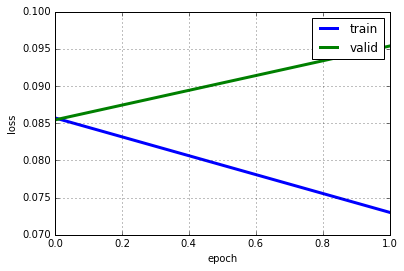

In [23]:
rmse = np.sqrt(np.min(history4.history['val_loss'])) * 48
print("Root Mean Square Error: {}".format(rmse))
%matplotlib inline
EpochDrawer(history4)

# import joblib
# joblib.dump(model3, "model3.pckl", "wb", compress=3, protocol=-1)